In [59]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv('../data/cleaned_data.csv')
print(df.columns)
print(df.dtypes)

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'holiday_type',
       'locale', 'transferred', 'dcoilwtico', 'city', 'state', 'store_type',
       'cluster', 'transactions', 'year', 'month', 'week', 'quarter',
       'day_of_week', 'is_crisis', 'sales_lag_7', 'rolling_mean_7',
       'is_weekend', 'is_holiday', 'promo_last_7_days', 'days_to_holiday',
       'promotion_status'],
      dtype='object')
date                  object
store_nbr              int64
family                object
sales                float64
onpromotion            int64
holiday_type          object
locale                object
transferred             bool
dcoilwtico           float64
city                  object
state                 object
store_type            object
cluster                int64
transactions         float64
year                   int64
month                  int64
week                   int64
quarter                int64
day_of_week           object
is_crisis              int64
sa

## Changing date column data type from object to datetime

In [61]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
print(df.dtypes)

date                 datetime64[ns]
store_nbr                     int64
family                       object
sales                       float64
onpromotion                   int64
holiday_type                 object
locale                       object
transferred                    bool
dcoilwtico                  float64
city                         object
state                        object
store_type                   object
cluster                       int64
transactions                float64
year                          int64
month                         int64
week                          int64
quarter                       int64
day_of_week                  object
is_crisis                     int64
sales_lag_7                 float64
rolling_mean_7              float64
is_weekend                    int64
is_holiday                    int64
promo_last_7_days           float64
days_to_holiday               int64
promotion_status             object
dtype: object


In [62]:
df.head()

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,transferred,dcoilwtico,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week,is_crisis,sales_lag_7,rolling_mean_7,is_weekend,is_holiday,promo_last_7_days,days_to_holiday,promotion_status
0,2013-01-01,1,AUTOMOTIVE,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
1,2013-01-01,1,BABY CARE,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
2,2013-01-01,1,BEAUTY,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
3,2013-01-01,1,BEVERAGES,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion
4,2013-01-01,1,BOOKS,0.00,0,Holiday,National,False,93.14,Quito,Pichincha,D,13,0.00,2013,1,1,1,Tuesday,0,0.00,0.00,0,1,0.00,0,Not On Promotion


# Time-Based Split of Data

The data is split into **training** and **testing** sets based on the `date` column. The training set contains data before `2017-01-01`, and the testing set contains data from `2017-01-01` onward.


In [63]:
train_df = df[df['date'] < '2017-01-01']
test_df = df[df['date'] >= '2017-01-01']

# Log Transformation of Target Variable

We apply a log transformation to the `sales` column to reduce the impact of outliers and stabilize the variance.


In [64]:
y_train = np.log1p(train_df['sales'])
y_test = np.log1p(test_df['sales'])

# Drop Unnecessary Columns

We drop the `date` and `sales` columns from the feature set since `date` is not needed anymore, and `sales` is the target variable.


In [65]:
drop_cols = ['date', 'sales']
X_train = train_df.drop(columns=drop_cols)
X_test = test_df.drop(columns=drop_cols)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.dtypes)
print(X_test.dtypes)

(2642706, 25) (2642706,)
(411642, 25) (411642,)
store_nbr              int64
family                object
onpromotion            int64
holiday_type          object
locale                object
transferred             bool
dcoilwtico           float64
city                  object
state                 object
store_type            object
cluster                int64
transactions         float64
year                   int64
month                  int64
week                   int64
quarter                int64
day_of_week           object
is_crisis              int64
sales_lag_7          float64
rolling_mean_7       float64
is_weekend             int64
is_holiday             int64
promo_last_7_days    float64
days_to_holiday        int64
promotion_status      object
dtype: object
store_nbr              int64
family                object
onpromotion            int64
holiday_type          object
locale                object
transferred             bool
dcoilwtico           float64
city      

# Encode Categorical Columns

Categorical columns are label-encoded using the `LabelEncoder` to convert string labels into numeric values.


In [66]:

# Combine both train and test for consistent encoding
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# Detect categorical columns
categorical_cols = X_train_copy.select_dtypes(include=['object', 'category']).columns

# Separate by cardinality
low_cardinality = [col for col in categorical_cols if X_train_copy[col].nunique() <= 5]
high_cardinality = [col for col in categorical_cols if X_train_copy[col].nunique() > 5]

# --- One-Hot Encoding for low cardinality ---
OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
onehot_encoded_train = pd.DataFrame(
    onehot_encoder.fit_transform(X_train_copy[low_cardinality]),
    columns=onehot_encoder.get_feature_names_out(low_cardinality),
    index=X_train_copy.index
)
onehot_encoded_test = pd.DataFrame(
    onehot_encoder.transform(X_test_copy[low_cardinality]),
    columns=onehot_encoder.get_feature_names_out(low_cardinality),
    index=X_test_copy.index
)

# --- Target Encoding for high cardinality ---
target_encoder = TargetEncoder()
target_encoded_train = target_encoder.fit_transform(X_train_copy[high_cardinality], y_train)
target_encoded_test = target_encoder.transform(X_test_copy[high_cardinality])

# --- Final dataset ---
X_train_final = X_train_copy.drop(columns=low_cardinality + high_cardinality)
X_test_final = X_test_copy.drop(columns=low_cardinality + high_cardinality)

X_train_final = pd.concat([X_train_final, onehot_encoded_train, target_encoded_train], axis=1)
X_test_final = pd.concat([X_test_final, onehot_encoded_test, target_encoded_test], axis=1)


In [67]:
# Combine both train and test for consistent encoding
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# Detect categorical columns
categorical_cols = X_train_copy.select_dtypes(include=['object', 'category']).columns

# Separate by cardinality
low_cardinality = [col for col in categorical_cols if X_train_copy[col].nunique() <= 5]
high_cardinality = [col for col in categorical_cols if X_train_copy[col].nunique() > 5]

# Ensure low_cardinality columns are all strings (to avoid mixed data types)
X_train_copy[low_cardinality] = X_train_copy[low_cardinality].astype(str)
X_test_copy[low_cardinality] = X_test_copy[low_cardinality].astype(str)

# --- One-Hot Encoding for low cardinality ---
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
onehot_encoded_train = pd.DataFrame(
    onehot_encoder.fit_transform(X_train_copy[low_cardinality]),
    columns=onehot_encoder.get_feature_names_out(low_cardinality),
    index=X_train_copy.index
)
onehot_encoded_test = pd.DataFrame(
    onehot_encoder.transform(X_test_copy[low_cardinality]),
    columns=onehot_encoder.get_feature_names_out(low_cardinality),
    index=X_test_copy.index
)

# --- Target Encoding for high cardinality ---
target_encoder = TargetEncoder()
target_encoded_train = target_encoder.fit_transform(X_train_copy[high_cardinality], y_train)
target_encoded_test = target_encoder.transform(X_test_copy[high_cardinality])

# --- Final dataset ---
X_train_final = X_train_copy.drop(columns=low_cardinality + high_cardinality)
X_test_final = X_test_copy.drop(columns=low_cardinality + high_cardinality)

X_train_final = pd.concat([X_train_final, onehot_encoded_train, target_encoded_train], axis=1)
X_test_final = pd.concat([X_test_final, onehot_encoded_test, target_encoded_test], axis=1)

# Ensure no 'object' types remain
X_train_final = X_train_final.apply(pd.to_numeric, errors='ignore')
X_test_final = X_test_final.apply(pd.to_numeric, errors='ignore')

# Fill missing values (if any)
X_train_final = X_train_final.fillna(-1)
X_test_final = X_test_final.fillna(-1)

# Check the final data types
print(X_train_final.dtypes)
print(X_test_final.dtypes)
# Check for any remaining 'object' types
print(X_train_final.select_dtypes(include=['object']).columns)
print(X_test_final.select_dtypes(include=['object']).columns)




store_nbr                          int64
onpromotion                        int64
transferred                         bool
dcoilwtico                       float64
cluster                            int64
transactions                     float64
year                               int64
month                              int64
week                               int64
quarter                            int64
is_crisis                          int64
sales_lag_7                      float64
rolling_mean_7                   float64
is_weekend                         int64
is_holiday                         int64
promo_last_7_days                float64
days_to_holiday                    int64
locale_National                  float64
locale_Regional                  float64
locale_nan                       float64
store_type_B                     float64
store_type_C                     float64
store_type_D                     float64
store_type_E                     float64
promotion_status

# Handle Missing Values

If there are any missing values in the dataset, we fill them with a placeholder value of `-1`.


In [68]:
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)
print(X_train.isnull().sum())
print(X_test.isnull().sum())

store_nbr            0
family               0
onpromotion          0
holiday_type         0
locale               0
transferred          0
dcoilwtico           0
city                 0
state                0
store_type           0
cluster              0
transactions         0
year                 0
month                0
week                 0
quarter              0
day_of_week          0
is_crisis            0
sales_lag_7          0
rolling_mean_7       0
is_weekend           0
is_holiday           0
promo_last_7_days    0
days_to_holiday      0
promotion_status     0
dtype: int64
store_nbr            0
family               0
onpromotion          0
holiday_type         0
locale               0
transferred          0
dcoilwtico           0
city                 0
state                0
store_type           0
cluster              0
transactions         0
year                 0
month                0
week                 0
quarter              0
day_of_week          0
is_crisis            

# Convert Boolean Columns to Integer

Boolean columns like `transferred` are converted to integer (`1` or `0`) format for compatibility with XGBoost.


In [69]:
X_train['transferred'] = X_train['transferred'].astype(int)
X_test['transferred'] = X_test['transferred'].astype(int)


# XGBoost Model Setup

We initialize the `XGBRegressor` with chosen hyperparameters such as `n_estimators`, `learning_rate`, and `max_depth`.


In [70]:
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


# Train the Model

We train the `XGBoost` model using the prepared training data (`X_train` and `y_train`).


In [71]:
model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:family: object, holiday_type: object, locale: object, city: object, state: object, store_type: object, day_of_week: object, promotion_status: object

# Make Predictions and Reverse Log Transformation

After making predictions, we reverse the log transformation on the predicted values to obtain the actual sales values.


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

# Model Evaluation

We calculate the **Root Mean Squared Error (RMSE)** between the predicted and actual sales values to evaluate the model's performance.


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
print(f"Test RMSE: {rmse:.2f}")
#rmse
#mse 
#r2score 

Test RMSE: 376.44


# Feature Importance Plot

We visualize the importance of each feature based on the trained model to understand which features contributed most to the predictions.


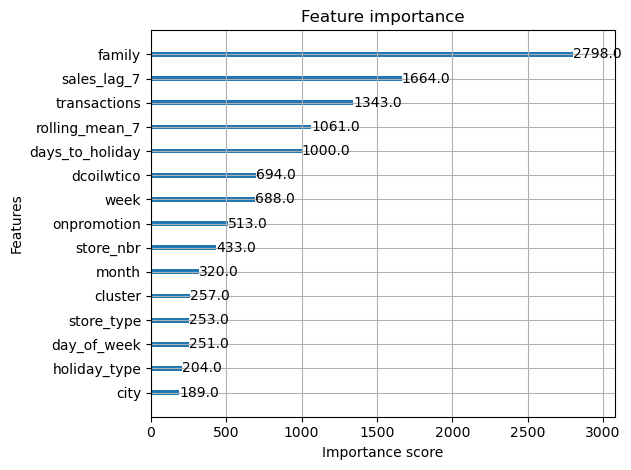

In [ ]:
xgb.plot_importance(model, max_num_features=15)
plt.tight_layout()
plt.show()